In [1]:
import pandas as pd
import numpy as np
import scipy.optimize
import scipy.stats
import seaborn as sns
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from collections import Counter


In [2]:
listings = pd.read_csv("test_data/Test_data.csv", sep=";")
sigVars = ['GUID','REGISTRATION_YEAR', 'MILEAGE', 'POWER_IN_KW', 'HORSEPOWER', 'GEARING_TYPE',
       'WARRANTY',
       'PRICE_PUBLIC', 'CYLINDERS', 'EMISSION_CLASS', 'PRIMARY_FUEL_TYPE',
       'CONSUMPTION_HIGHWAY', 'CONSUMPTION_CITY', 'CONSUMPTION_MIXED',
       'ELECTRIC_CONSUMPTION_MIXED', 'EFFICIENCY_CLASS', 'CO2_EMISSION', 'EMISSION_STICKER', 'PREV_OWNERS', 'SEATS']
listings_processed = listings[sigVars]
numericVars = ['REGISTRATION_YEAR', 'MILEAGE','POWER_IN_KW', 'HORSEPOWER',
       'PRICE_PUBLIC',
       'CYLINDERS',
       'CONSUMPTION_HIGHWAY', 'CONSUMPTION_CITY', 'CONSUMPTION_MIXED', 'ELECTRIC_CONSUMPTION_MIXED', 'CO2_EMISSION', 'PREV_OWNERS', 'SEATS']
listings_numeric = listings[numericVars]
n_std = 2

df2 = listings.dropna(subset='ELECTRIC_CONSUMPTION_MIXED')
df2_num = df2[numericVars]

for col in listings_numeric.columns:
    if col != 'ELECTRIC_CONSUMPTION_MIXED':
        mean = listings_numeric[col].mean()
        sd = listings_numeric[col].std()
        listings_numeric = listings_numeric[listings_numeric[col] <= mean+(n_std*sd)]
    elif col == 'ELECTRIC_CONSUMPTION_MIXED':
       # print(df2_num)
        pass


In [3]:
print(listings.head())

                                   GUID COUNTRY_ID    MAKENAME MAKENAME_LINK  \
0  50e507d3-8edf-40e7-931d-d4a172d85441         DE  Volkswagen    Volkswagen   
1  c0dbe46a-4513-407f-9e10-d8423b7913de         DE        Audi          Audi   
2  77a24a53-50cd-4bc9-b29f-02998ca84ea9         DE         BMW           BMW   
3  1ceef883-3707-40b1-b723-42f2e6e59a14         DE        Audi          Audi   
4  1e17705e-ed7a-4a32-9e79-a3d90f662107         DE        Jeep          Jeep   

    MODELNAME MODELNAME_LINK                                            TITLE  \
0  New Beetle     New-Beetle              Volkswagen New Beetle Cabriolet 1.6   
1          Q5             Q5                          Audi Q5 2.0 TDI quattro   
2         118            118  BMW 118 i Sport Line Sportsitze PDC Servotronic   
3          A3             A3  Audi A3 Lim. Ambiente*Xenon*Klima*SHZ*Teilleder   
4     Compass        Compass                Jeep Compass 80th Anniversary FWD   

   REGISTRATION_YEAR DEALER_LONG

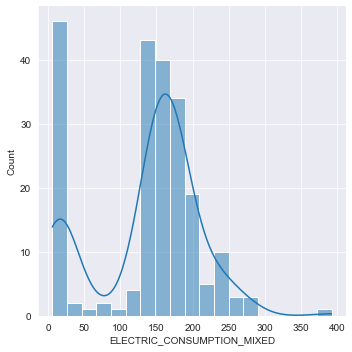

In [4]:
sns.displot(df2_num['ELECTRIC_CONSUMPTION_MIXED'], kde = True, stat = 'count')

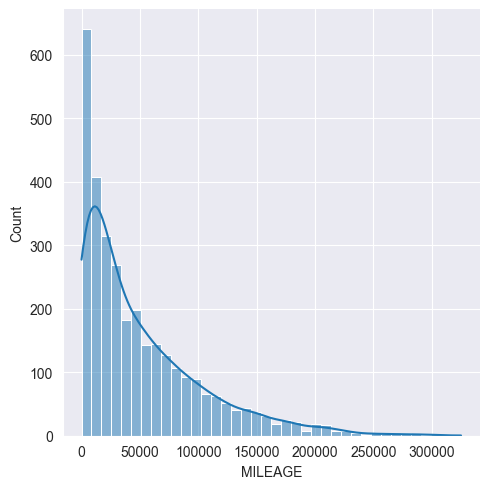

In [5]:
sns.displot(listings_numeric['MILEAGE'], kde = True, stat = 'count')

265.0
200
[ 27.          28.1959799   29.3919598   30.5879397   31.7839196
  32.9798995   34.1758794   35.3718593   36.5678392   37.7638191
  38.95979899  40.15577889  41.35175879  42.54773869  43.74371859
  44.93969849  46.13567839  47.33165829  48.52763819  49.72361809
  50.91959799  52.11557789  53.31155779  54.50753769  55.70351759
  56.89949749  58.09547739  59.29145729  60.48743719  61.68341709
  62.87939698  64.07537688  65.27135678  66.46733668  67.66331658
  68.85929648  70.05527638  71.25125628  72.44723618  73.64321608
  74.83919598  76.03517588  77.23115578  78.42713568  79.62311558
  80.81909548  82.01507538  83.21105528  84.40703518  85.60301508
  86.79899497  87.99497487  89.19095477  90.38693467  91.58291457
  92.77889447  93.97487437  95.17085427  96.36683417  97.56281407
  98.75879397  99.95477387 101.15075377 102.34673367 103.54271357
 104.73869347 105.93467337 107.13065327 108.32663317 109.52261307
 110.71859296 111.91457286 113.11055276 114.30653266 115.50251256
 1

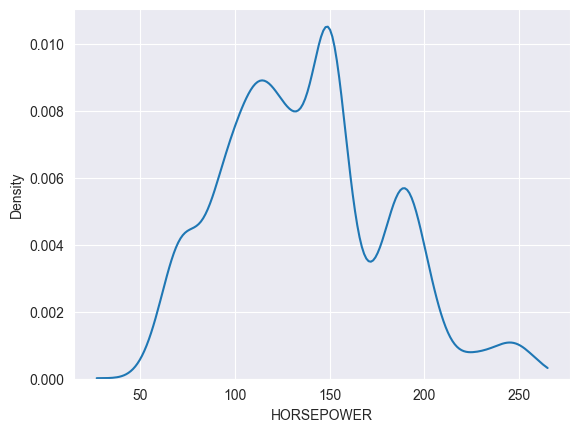

In [6]:
# x,y = sns.distplot(listings_numeric['HORSEPOWER'], hist=False).get_lines()[0].get_data()
x,y = sns.kdeplot(listings_numeric['HORSEPOWER'], cut=0).get_lines()[0].get_data()
#density = sns.kdeplot(listings_numeric['HORSEPOWER']).get_lines()[0]
#print(type(density))
print(np.max(x))
print(len(y))
print(x)

200
325000.0
[1.00000000e+00 1.63416080e+03 3.26732161e+03 4.90048241e+03
 6.53364322e+03 8.16680402e+03 9.79996482e+03 1.14331256e+04
 1.30662864e+04 1.46994472e+04 1.63326080e+04 1.79657688e+04
 1.95989296e+04 2.12320905e+04 2.28652513e+04 2.44984121e+04
 2.61315729e+04 2.77647337e+04 2.93978945e+04 3.10310553e+04
 3.26642161e+04 3.42973769e+04 3.59305377e+04 3.75636985e+04
 3.91968593e+04 4.08300201e+04 4.24631809e+04 4.40963417e+04
 4.57295025e+04 4.73626633e+04 4.89958241e+04 5.06289849e+04
 5.22621457e+04 5.38953065e+04 5.55284673e+04 5.71616281e+04
 5.87947889e+04 6.04279497e+04 6.20611106e+04 6.36942714e+04
 6.53274322e+04 6.69605930e+04 6.85937538e+04 7.02269146e+04
 7.18600754e+04 7.34932362e+04 7.51263970e+04 7.67595578e+04
 7.83927186e+04 8.00258794e+04 8.16590402e+04 8.32922010e+04
 8.49253618e+04 8.65585226e+04 8.81916834e+04 8.98248442e+04
 9.14580050e+04 9.30911658e+04 9.47243266e+04 9.63574874e+04
 9.79906482e+04 9.96238090e+04 1.01256970e+05 1.02890131e+05
 1.04523291

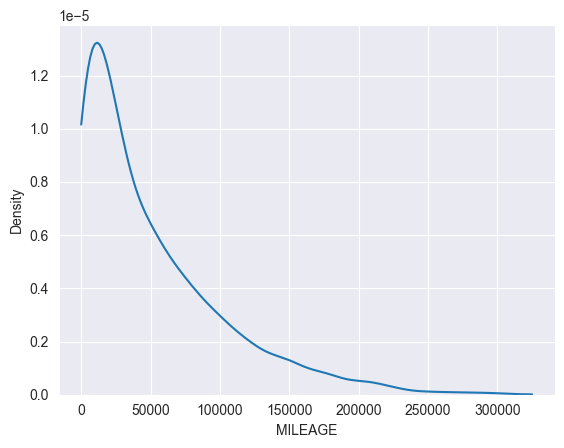

In [7]:
x_m,y_m = sns.kdeplot(listings_numeric['MILEAGE'], cut=0).get_lines()[0].get_data()
print(len(x_m))
print(np.max(x_m))
print(x_m)

In [8]:
def PolyCoefficients(x, coeffs):
    """ Returns a polynomial for ``x`` values for the ``coeffs`` provided.
        The coefficients must be in ascending order (``x**0`` to ``x**o``).
    """

    o = len(coeffs)
    rev_coeffs = coeffs[::-1]
    print(f'# This is a polynomial of order {o}.')
    y = 0
    for i in range(o):
        y += rev_coeffs[i] * x ** i

    return y

# This is a polynomial of order 16.


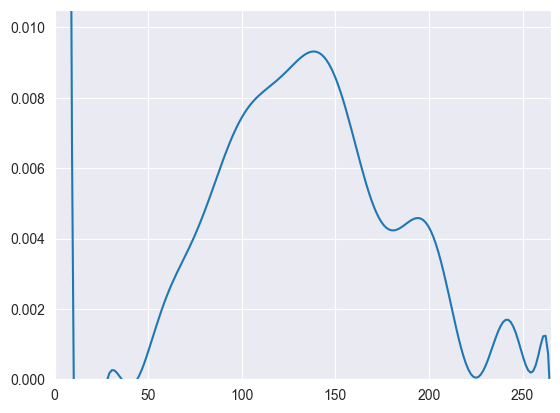

In [9]:
coeffs10 = np.polyfit(x,y, 15)
fx = np.linspace(0,np.max(x),len(x))
function = PolyCoefficients(fx, coeffs10)

plt.xlim(0, np.max(x))
plt.ylim(0, np.max(y))
plt.plot(fx, function)
plt.show()


# This is a polynomial of order 11.


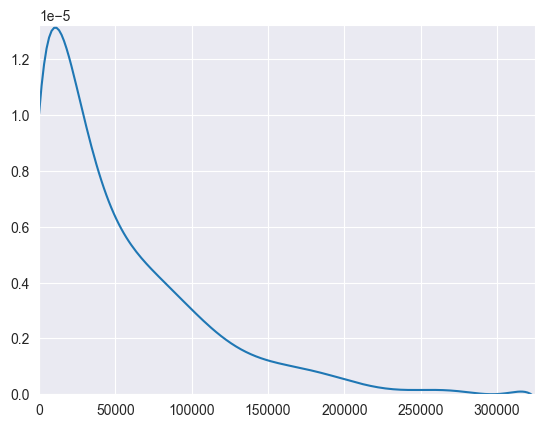

In [10]:
coeffs_m = np.polyfit(x_m,y_m, 10)
fx_m = np.linspace(0,np.max(x_m),len(x_m))
function_m = PolyCoefficients(fx_m, coeffs_m)
plt.xlim(0, np.max(x_m))
plt.ylim(0, np.max(y_m))
plt.plot(fx_m, function_m)
plt.show()

In [11]:
def plot_comparison(apprx_function, density_x, density_y):
    """ Takes in the approximated functionand plots it against the extracted density.
    """
    fx = np.linspace(0, np.max(density_x), len(density_x))

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10), sharex='all')
    fig.suptitle('Comparison of density and approximation.')
    ax = fig.add_subplot(1, 1, 1)
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')


    # plot the function
    plt.subplot(1, 2, 1)
    #plt.xlim(0, np.max(density_x))
    #plt.ylim(0, np.max(density_y))
    plt.plot(fx, density_y, 'r.-')
    plt.ylabel('Density')

    plt.subplot(1, 2, 2)
    plt.plot(fx, apprx_function, 'ko-')
    plt.ylabel('Approximation')

    plt.tight_layout()
    plt.show()


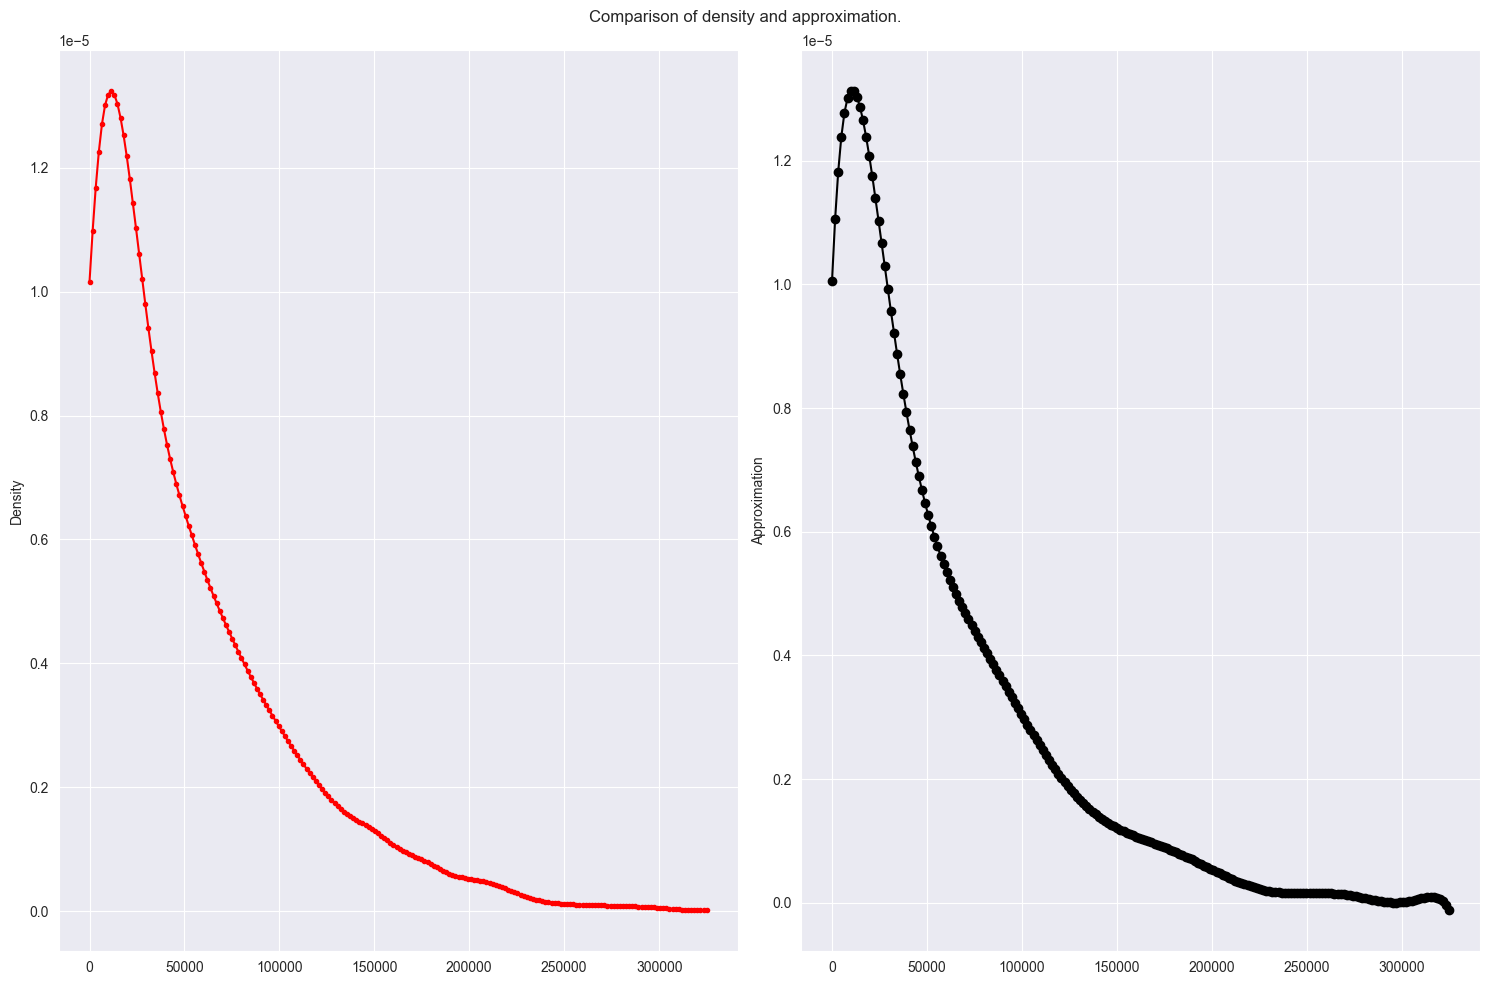

In [12]:
plot_comparison(function_m, x_m, y_m)

In [13]:
perc = np.percentile(x_m, 60)
median = np.median(x_m)
print(perc)
print(median)

195000.4
162500.5


In [14]:
scale = [1,2,3,4,5,6,7,8,9,10]
#scale = scale[::-1]
mapping = map(lambda perc : np.percentile(x_m, perc * 10), scale)
# print(list(mapping))
scoring = list(mapping)[::-1]
print(scoring)

[325000.0, 292500.10000000003, 260000.20000000007, 227500.3, 195000.4, 162500.5, 130000.60000000002, 97500.7, 65000.80000000001, 32500.900000000005]


In [15]:
scale = [1,2,3,4,5,6,7,8,9,10]
scale = scale[::-1]
mapping = map(lambda perc : np.percentile(x, perc * 10), scale)
# print(list(mapping))
scoring = list(mapping)[::-1]
print(scoring)

[50.800000000000004, 74.60000000000001, 98.4, 122.20000000000002, 146.0, 169.79999999999998, 193.59999999999997, 217.40000000000003, 241.2, 265.0]


In [17]:
scale = [1,2,3,4,5,6,7,8,9,10]
scale = scale[::-1]
mapping = map(lambda perc : np.percentile(listings_numeric['MILEAGE'], perc * 10), scale)
# print(list(mapping))
scoring = list(mapping)[::-1]
print(scoring)

[1201.9000000000005, 8520.0, 15000.0, 23000.0, 33250.0, 47542.2, 64100.0, 87000.0, 124913.60000000003, 325000.0]


In [20]:
## Non-linear regression approach


svrrbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)

lw = 2

svrs = [svrrbf]
kernel_label = ["RBF"]
model_color = ["m"]

In [21]:
x = x.reshape(-1,1)
#y = y.reshape(-1,1)
y = y.ravel()
# print(x)

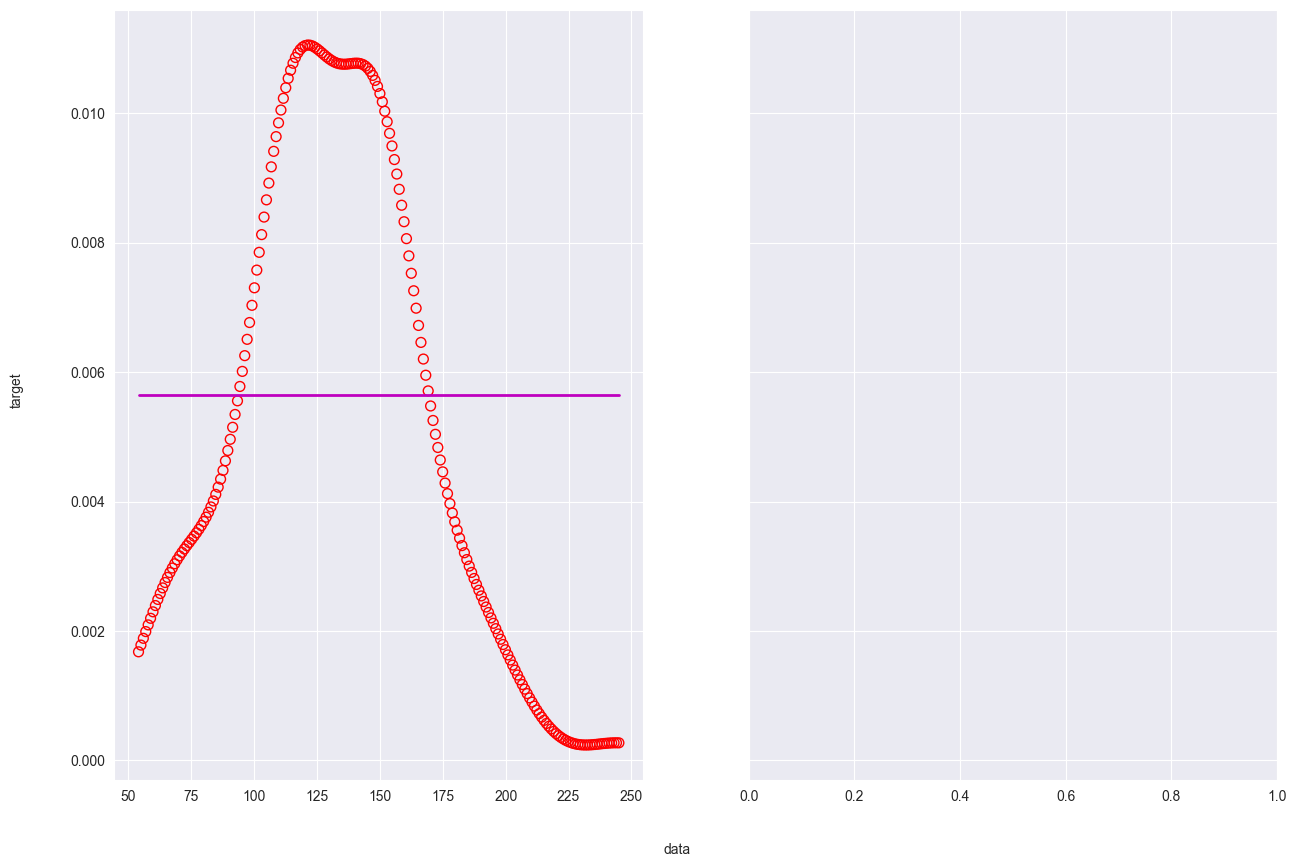

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10), sharey='all')
for ix, svr in enumerate(svrs):
    axes[ix].plot(
        x,
        svr.fit(x, y).predict(x),
        color=model_color[ix],
        lw=lw,
        label="{} model".format(kernel_label[ix]),
    )
    axes[ix].scatter(
        x[svr.support_],
        y[svr.support_],
        facecolor="none",
        edgecolor=model_color[ix],
        s=50,
        label="{} support vectors".format(kernel_label[ix]),
    )
    axes[ix].scatter(
        x[np.setdiff1d(np.arange(len(x)), svr.support_)],
        y[np.setdiff1d(np.arange(len(x)), svr.support_)],
        facecolor="none",
        edgecolor="r",
        s=50,
        label="other training data",
    )

fig.text(0.5, 0.04, "data", ha="center", va="center")
fig.text(0.06, 0.5, "target", ha="center", va="center", rotation="vertical")
plt.show()

In [23]:
# Non-linear regression second approach
x_data, y_data = (listings_numeric["HORSEPOWER"].values, listings_numeric["HORSEPOWER"].values)
c = Counter(listings_numeric["HORSEPOWER"])

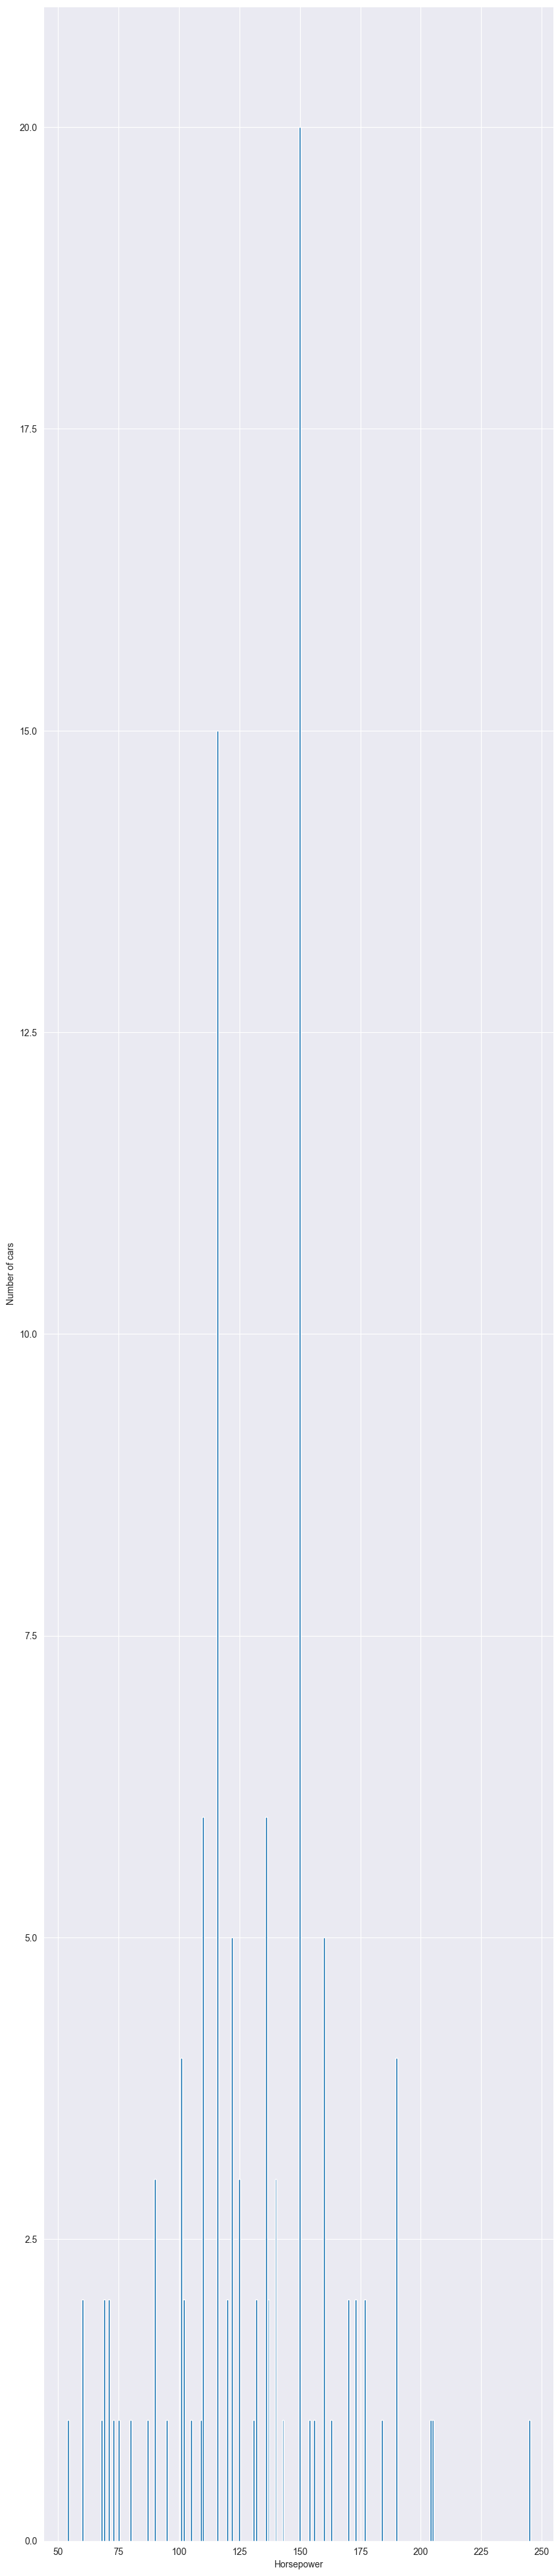

<Figure size 640x480 with 0 Axes>

In [24]:
plt.figure(figsize=(10,50))
#plt.plot(x_data, y_data, 'ro')
plt.bar(c.keys(), c.values())
plt.ylabel('Number of cars')
plt.xlabel('Horsepower')
plt.show()
plt.tight_layout()

In [25]:
x_data, y_data = c.keys(), c.values()

In [26]:
def sigmoid(x, Beta_1, Beta_2):
    for i in range(int(Beta_2)):
        y = 1 / (1 + np.exp(-Beta_1*(x-Beta_2)))
    return y
beta1 = 0.10
beta2 = 1990.0
#logistic function
Y_pred = sigmoid(x_data, beta1 , beta2)

plt.plot(x_data, Y_pred*15000000000000.)
plt.plot(x_data, y_data, 'ro')

TypeError: 'float' object is not iterable